In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')
from google.colab import files
uploaded = files.upload()

from IPython.display import display
import IPython
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os,sys
#os.chdir('/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/')
#FILE_PATH='/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/data.csv'
FILE_PATH='/content.data.csv'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## 데이터 불러오기

변수 총 13개

In [ ]:
data=pd.read_csv(FILE_PATH,encoding='cp437',index_col=0) #index_col : 어떤 컬럼을 인덱스로 쓸거냐
#data=pd.read_csv(FILE_PATH,encoding='cp437',index_col=0)
columns=list(data.columns);columns
y=data.iloc[:,-1:]
data=data.iloc[:,:-3] # 가수,제목 제거
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   int64  
 12  valence           2017 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 220.6 KB
None


## EDA 및 전처리

### 공백 체크

In [ ]:
print(data.isnull().sum())
print(data.drop_duplicates(inplace=True)) # Null 값이 존재하는 행 제거
#공백없음

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64
None


### 분포 확인

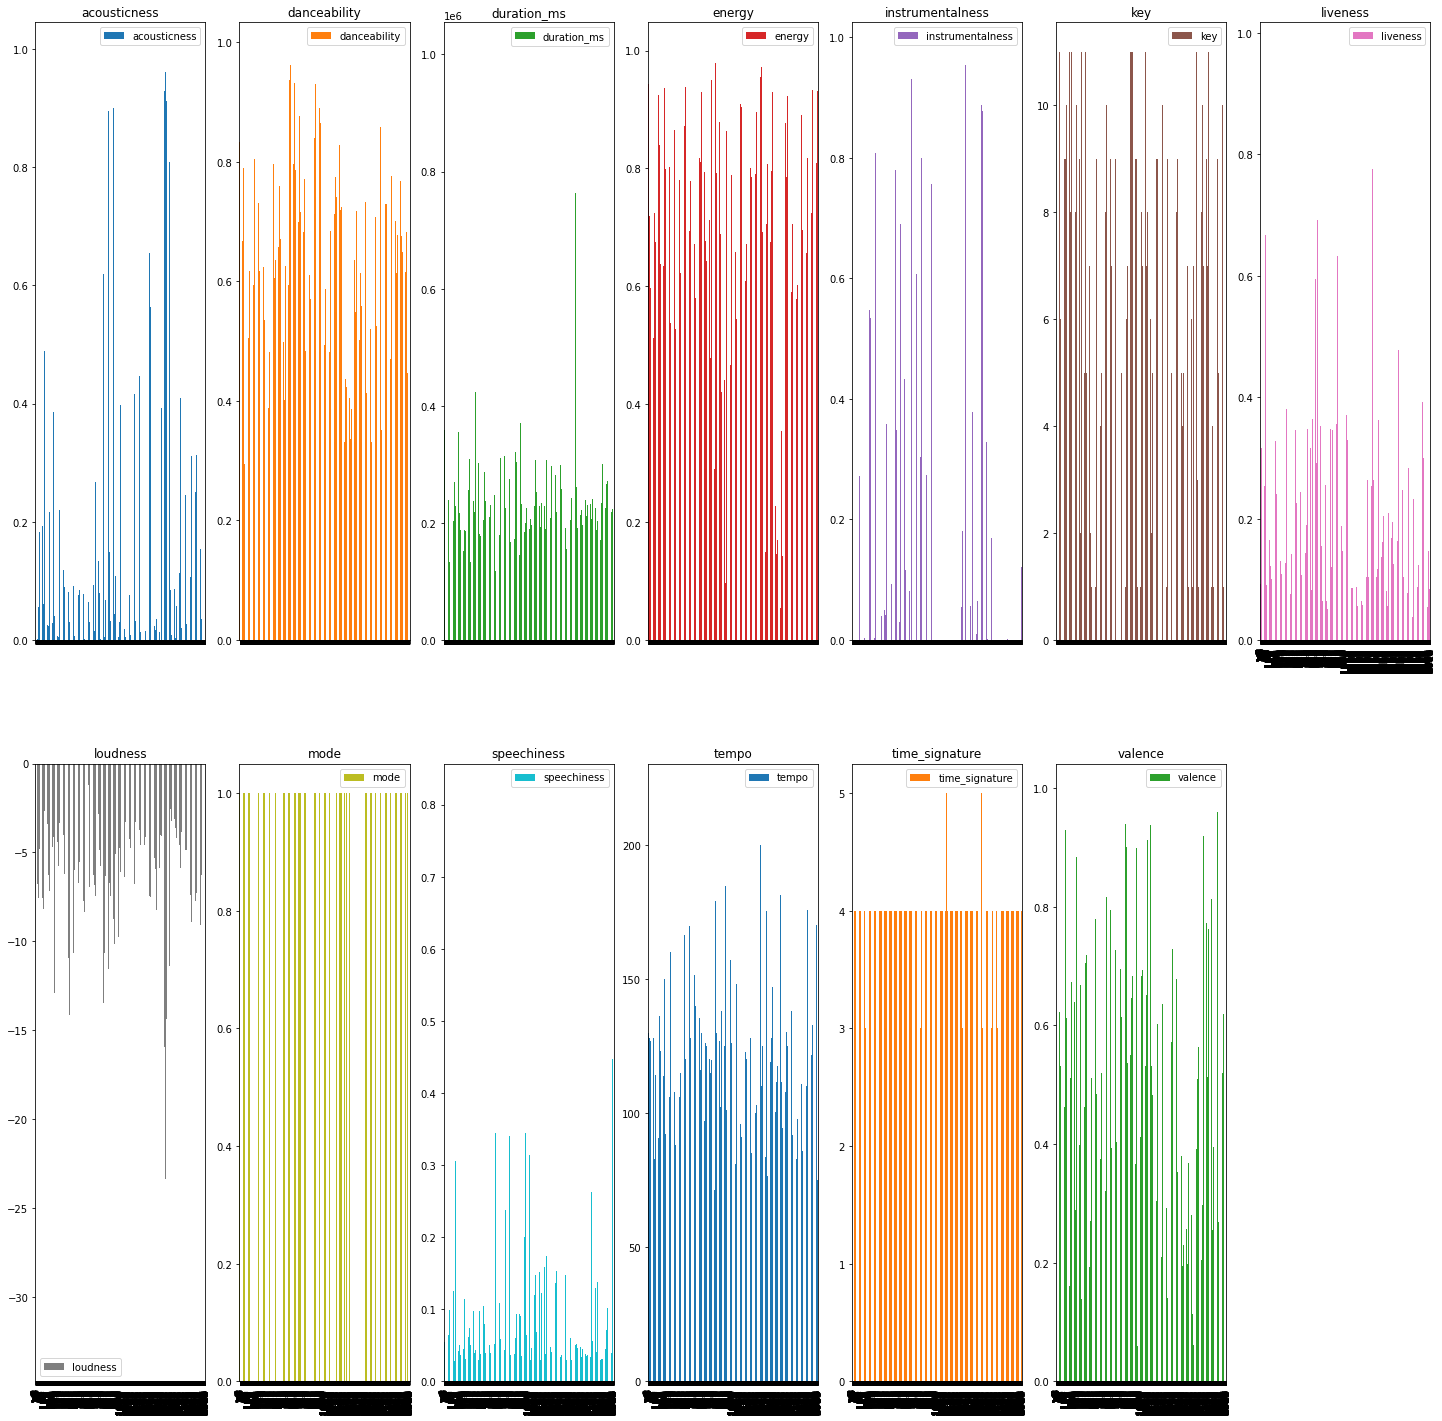

In [ ]:
data.plot(subplots=True,layout=(2,7),figsize=(25,25),kind='bar')
plt.show()

In [ ]:
flt_col,int_col,cat_col=[],[],[]
data['duration_ms']/=(1000*60)
data['duration_ms']=round(data['duration_ms'],2)
for index,dtype in zip(data.dtypes.index,data.dtypes.values):
  
  if dtype=='float64':
    flt_col.append(index)
  else:
    int_col.append(index)
flt_col,int_col

(['acousticness',
  'danceability',
  'duration_ms',
  'energy',
  'instrumentalness',
  'liveness',
  'loudness',
  'speechiness',
  'tempo',
  'valence'],
 ['key', 'mode', 'time_signature'])

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
mean,0.187590,0.618422,4.105151,0.681577,0.133286,0.190844,-7.085624,0.092664,121.603272,0.496815
std,0.259989,0.161029,1.366276,0.210273,0.273162,0.155453,3.761684,0.089931,26.685604,0.247195
min,0.000003,0.122000,0.270000,0.014800,0.000000,0.018800,-33.097000,0.023100,47.859000,0.034800
25%,0.009630,0.514000,3.330000,0.563000,0.000000,0.092300,-8.394000,0.037500,100.189000,0.295000
50%,0.063300,0.631000,3.820000,0.715000,0.000076,0.127000,-6.248000,0.054900,121.427000,0.492000
75%,0.265000,0.738000,4.510000,0.846000,0.054000,0.247000,-4.746000,0.108000,137.849000,0.691000
max,0.995000,0.984000,16.740000,0.998000,0.976000,0.969000,-0.307000,0.816000,219.331000,0.992000


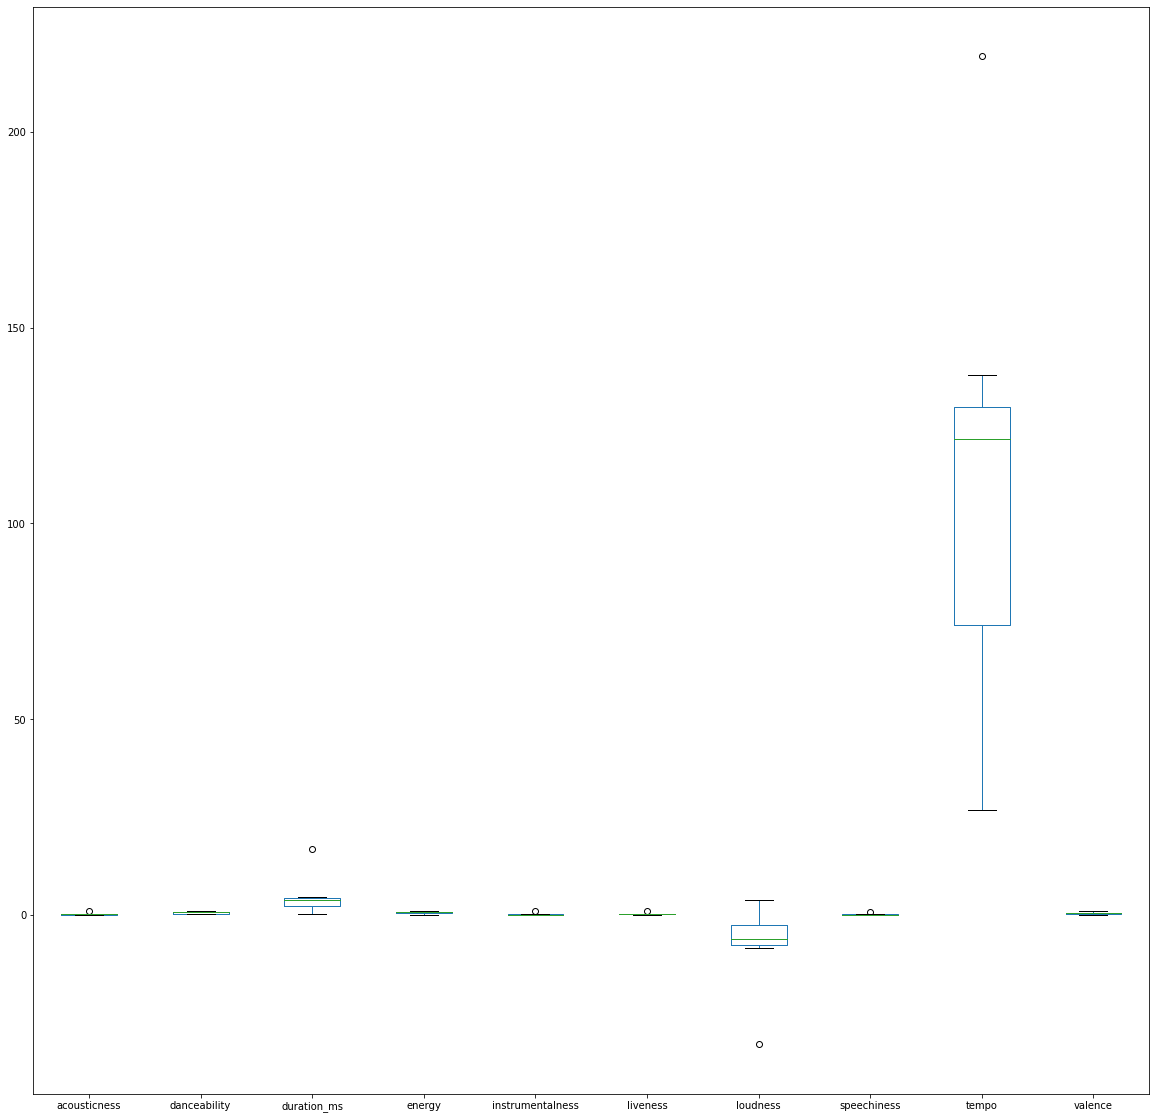

In [ ]:
import seaborn as sns
colors = sns.color_palette('hls',len(flt_col))
data.describe(include='float64').iloc[1:,:].plot(kind='box',figsize=(20,20))
data.describe(include='float64').iloc[1:,:]


time signiture 변수 제외 가능

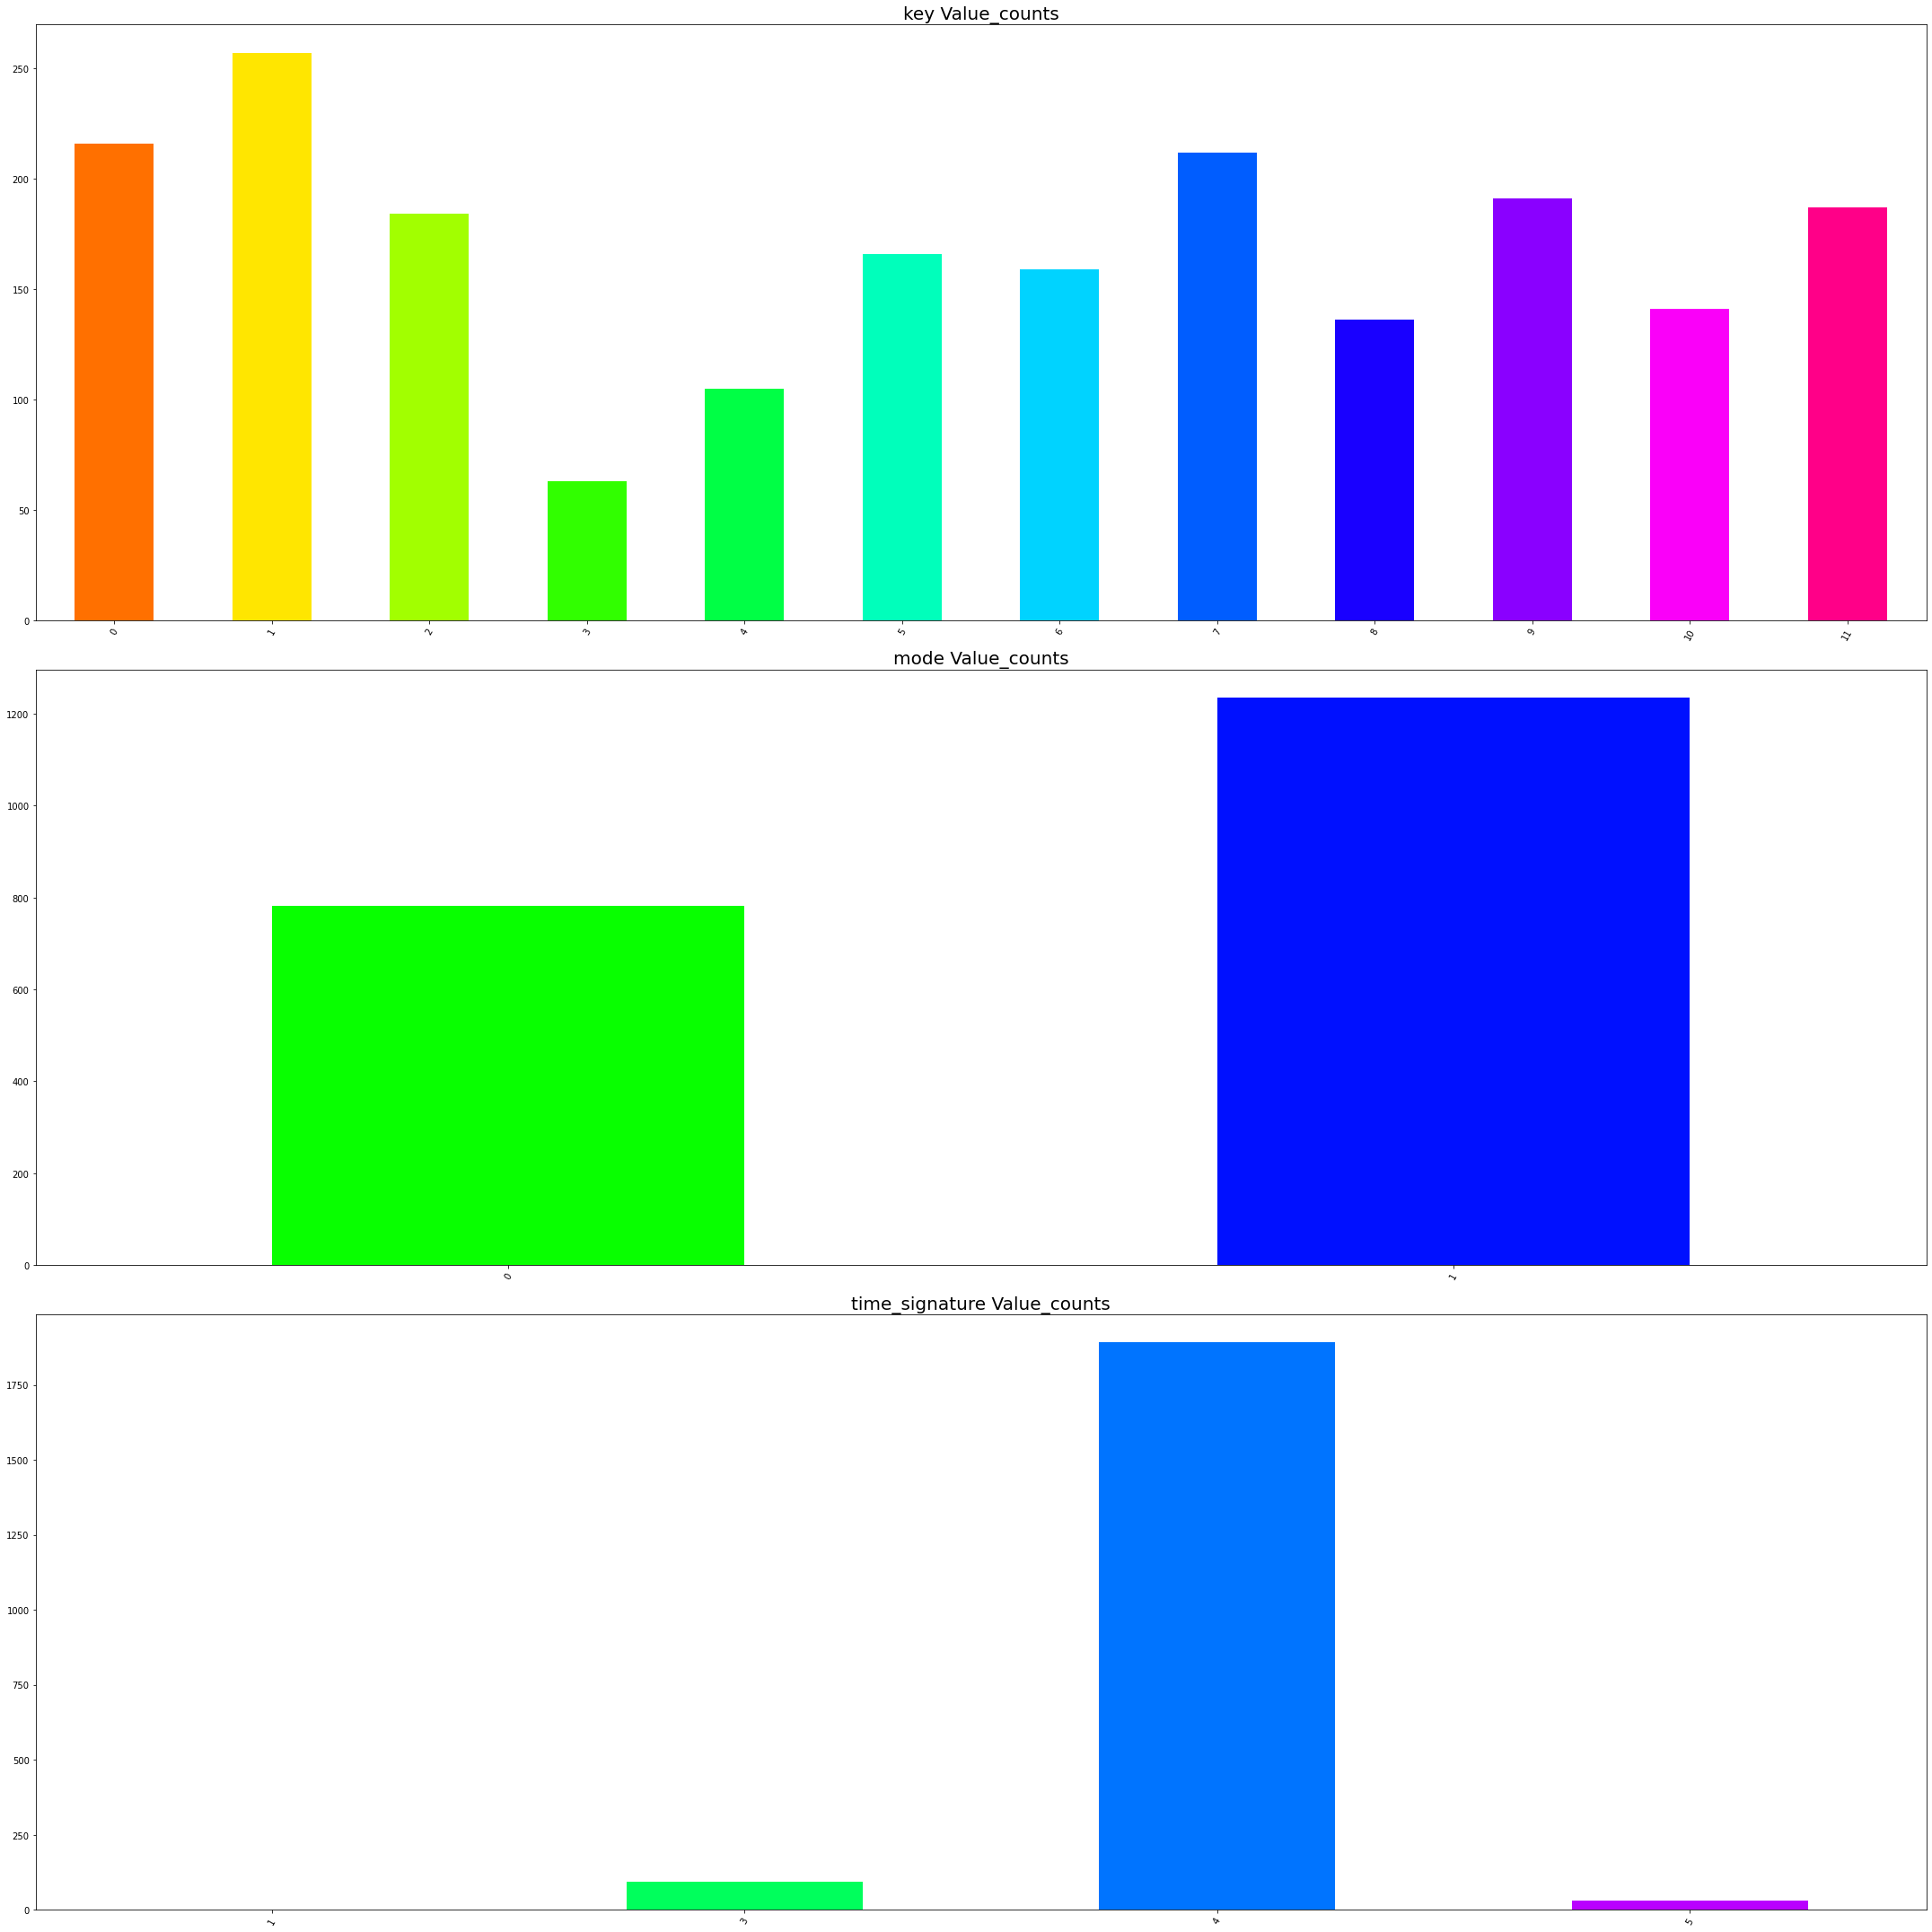

In [ ]:
plt.figure(figsize=(30,30))
for i,col in enumerate(int_col):
  import seaborn as sns
  colors = sns.color_palette('hsv',len(data[col].value_counts().sort_index()))
  ax=plt.subplot(3,1,i+1)
  plt.title(f'{col} Value_counts',fontsize=20)
  data[col].value_counts().sort_index().plot(kind='bar',color=colors)
  plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


### 상관관계 확인

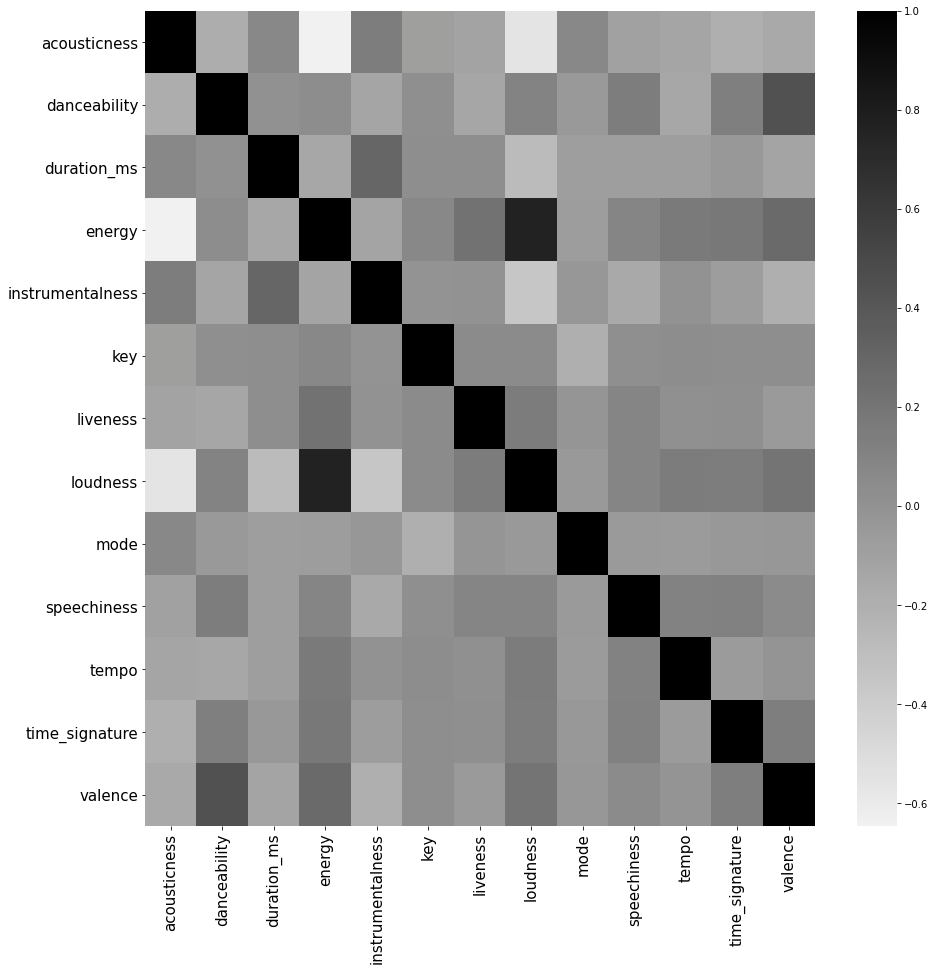

In [ ]:
import seaborn as sns                        #heatmap 만들기 위한 라이브러리
cmap = sns.light_palette("Black", as_cmap = True)  
plt.figure(figsize=(15,15))
plt.xticks(fontsize=15,rotation=60)
plt.yticks(fontsize=15)
sns.heatmap(data.corr(), annot = False, cmap = cmap)

plt.show()

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(data)
plt.show()

### 다중공선성

초기 변수

In [ ]:
from statsmodels.stats import outliers_influence as outliers_influence
#from outliers_influence import variance_inflation_factor
#import statsmodels.stats.ouliers_influence.variance_inflation_factor as variance_inflation_factor 

vif = pd.DataFrame()
vif["VIF Factor"] = [outliers_influence.variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif["features"] = data.columns
vif = vif.sort_values('VIF Factor',axis=0)
vif;col1=vif['features'][:-1];vif#,col1

,VIF Factor,features
4,1.645160,instrumentalness
9,2.233399,speechiness
0,2.630193,acousticness
8,2.677357,mode
6,2.735357,liveness
5,3.280699,key
12,7.229048,valence
2,11.606489,duration_ms
7,12.411358,loudness
10,20.789513,tempo


다중공선성 결과를 바탕으로 변수 제거 후 재확인

In [ ]:
col = [data.columns]
df = data
while True:
  try:
    vif = pd.DataFrame()
    vif["VIF Factor"] = [outliers_influence.variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    vif = vif.sort_values('VIF Factor',axis=0)
    if max(vif['VIF Factor']) <=10:
      break
    else:
      col=vif['features'][:-1]
      df=df[col]
      continue
  except:
    continue
vif
# 총 9개 변수만 남음

,VIF Factor,features
0,1.546169,instrumentalness
1,2.047553,speechiness
2,2.281422,acousticness
3,2.383877,mode
4,2.432860,liveness
5,2.965915,key
6,4.025178,valence
7,7.366587,loudness
8,8.267952,duration_ms


## 데이터분리

In [ ]:
data=pd.read_csv(FILE_PATH,encoding='cp437',index_col=0) #index_col : 어떤 컬럼을 인덱스로 쓸거냐
#data=pd.read_csv(FILE_PATH,encoding='cp437',index_col=0)
columns=list(data.columns);columns
y=data['target']
data=data.iloc[:,:-3] # 가수,제목 제거
print(data.info())
print(y.describe)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   int64  
 12  valence           2017 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 220.6 KB
None
<bound method NDFrame.describe of 0       1
1       1
2       1
3       1
4       1
       ..
2012    0
2013    0
2014    0
2015   

In [ ]:
data['duration_ms']/=(1000*60)
data['duration_ms']=round(data['duration_ms'],2)

In [ ]:
selected_features=vif.features
data=data[selected_features]
data.isnull().sum(),y.isnull().sum()

(instrumentalness    0
 speechiness         0
 acousticness        0
 mode                0
 liveness            0
 key                 0
 valence             0
 loudness            0
 duration_ms         0
 dtype: int64, 0)

In [ ]:
from sklearn.model_selection import train_test_split
# Train/ Test
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=3,stratify=y) 
print(len(x_train)) #[[6, 12], [7, 5], [2, 5], [9, 2], [3, 2], [2, 4], [8, 9], [9, 10]]
print(len(x_test)) #[[6, 10], [2, 1], [5, 5], [3, 4]]
print(len(y_train)) #[1, 1, 0, 1, 0, 0, 1, 1]
print(len(y_test)) #[1, 0, 1, 0]

1815
202
1815
202


In [ ]:
train=pd.concat([x_train,y_train],axis=1)
test=pd.concat([x_test,y_test],axis=1)
train.to_csv('/gdrive/Shareddrives/Spotify Recommendation/Train.csv',encoding='cp949')
test.to_csv('/gdrive/Shareddrives/Spotify Recommendation/Test.csv',encoding='cp949')